# ZERO INFLATED MODELS

## Load libraries

In [1]:
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

import bambi as bmb

warnings.simplefilter(action='ignore', category=FutureWarning)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Oct 10 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.15.0

scipy     : 1.11.3
matplotlib: 3.8.0
pandas    : 2.1.1
seaborn   : 0.12.2
numpy     : 1.25.2
bambi     : 0.13.0.dev0
arviz     : 0.16.1

Watermark: 2.4.3



## Simulate ZIP data

In [3]:
x = np.arange(0, 22)
psis = [0.7, 0.4]
mus = [10, 4]

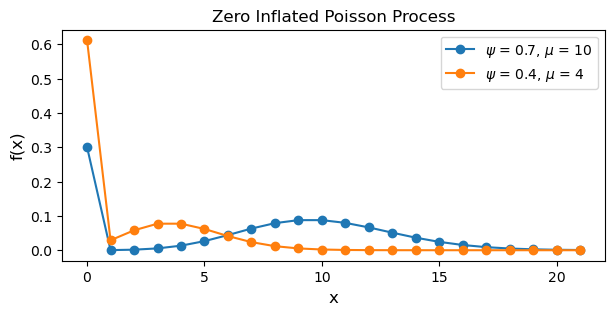

In [4]:
plt.figure(figsize=(7, 3))
for psi, mu in zip(psis, mus):
    pmf = stats.poisson.pmf(x, mu)
    pmf[0] = (1 - psi) + pmf[0] # 1.) generate zeros
    pmf[1:] =  psi * pmf[1:] # 2.) generate counts
    pmf /= pmf.sum() # normalize to get probabilities
    plt.plot(x, pmf, '-o', label='$\\psi$ = {}, $\\mu$ = {}'.format(psi, mu))
    
plt.title("Zero Inflated Poisson Process")
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

## Load data

In [5]:
fish_data = pd.read_stata("http://www.stata-press.com/data/r11/fish.dta")

fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1.0,0.0,0.0,1.0,0.0,-0.896315,3.050405,0.0
1,0.0,1.0,1.0,1.0,0.0,-0.558345,1.746149,0.0
2,0.0,1.0,0.0,1.0,0.0,-0.401731,0.279939,0.0
3,0.0,1.0,1.0,2.0,1.0,-0.956298,-0.601526,0.0
4,0.0,1.0,0.0,1.0,0.0,0.436891,0.527709,1.0


In [6]:
fish_data = (fish_data
             .filter(["count", "livebait", "camper", "persons", "child"])
             .assign(
                     livebait = lambda x: pd.Categorical(x['livebait']),
                     camper = lambda x: pd.Categorical(x['camper'])
             )
             .query('count < 60')

)

fish_data.head()

,count,livebait,camper,persons,child
0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,1.0,2.0,1.0
4,1.0,1.0,0.0,1.0,0.0


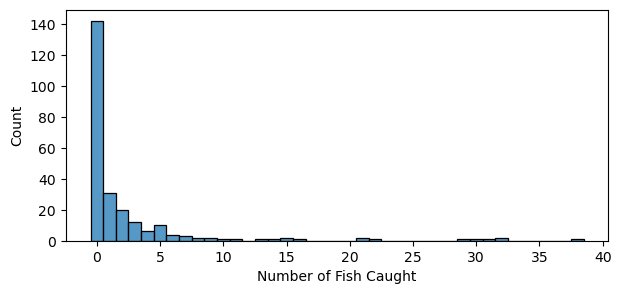

In [7]:
# Excess zeros, and skewed count
plt.figure(figsize=(7, 3))
sns.histplot(fish_data["count"], discrete=True)
plt.xlabel("Number of Fish Caught");

## ZIP Model

In [8]:
zip_model = bmb.Model(
                        "count ~ livebait + camper + persons + child",
                        fish_data,
                        family = 'zero_inflated_poisson'
)

In [9]:
zip_idata = zip_model.fit(
                            draws=1000,
                            target_accept=0.95, 
                            random_seed=1234, 
                            chains=4
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [count_psi, Intercept, livebait, camper, persons, child]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.


In [10]:
zip_model

       Formula: count ~ livebait + camper + persons + child
        Family: zero_inflated_poisson
          Link: mu = log
  Observations: 248
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 9.5283)
            livebait ~ Normal(mu: 0.0, sigma: 7.2685)
            camper ~ Normal(mu: 0.0, sigma: 5.0733)
            persons ~ Normal(mu: 0.0, sigma: 2.2583)
            child ~ Normal(mu: 0.0, sigma: 2.9419)
        
        Auxiliary parameters
            psi ~ Beta(alpha: 2.0, beta: 2.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [11]:
formula = bmb.Formula(
                        "count ~ livebait + camper + persons + child", # parent parameter mu
                        "psi ~ livebait + camper + persons + child"    # non-parent parameter psi
)

In [12]:
zip_model = bmb.Model(
                        formula,
                        fish_data,
                        family = 'zero_inflated_poisson'
)

In [13]:
zip_idata = zip_model.fit(
    draws=1000, 
    target_accept=0.95, 
    random_seed=1234, 
    chains=4
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, livebait, camper, persons, child, psi_Intercept, psi_livebait, psi_camper, psi_persons, psi_child]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.


In [14]:
zip_model

       Formula: count ~ livebait + camper + persons + child
                psi ~ livebait + camper + persons + child
        Family: zero_inflated_poisson
          Link: mu = log
                psi = logit
  Observations: 248
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 9.5283)
            livebait ~ Normal(mu: 0.0, sigma: 7.2685)
            camper ~ Normal(mu: 0.0, sigma: 5.0733)
            persons ~ Normal(mu: 0.0, sigma: 2.2583)
            child ~ Normal(mu: 0.0, sigma: 2.9419)
    target = psi
        Common-level effects
            psi_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            psi_livebait ~ Normal(mu: 0.0, sigma: 1.0)
            psi_camper ~ Normal(mu: 0.0, sigma: 1.0)
            psi_persons ~ Normal(mu: 0.0, sigma: 1.0)
            psi_child ~ Normal(mu: 0.0, sigma: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object

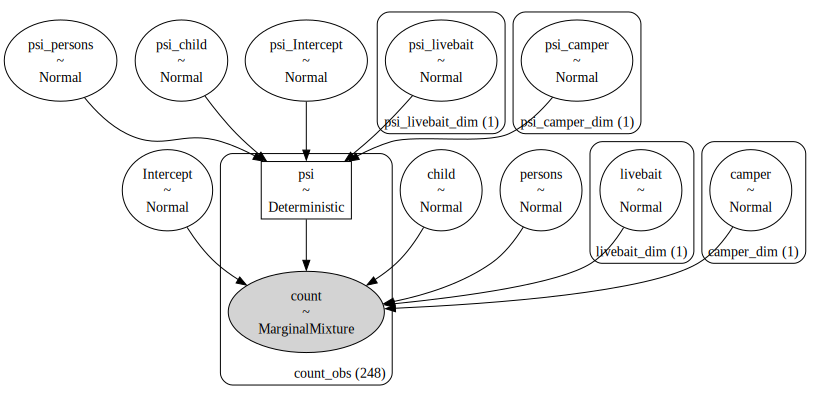

In [15]:
zip_model.graph()

In [16]:
az.summary(
    zip_idata, 
    var_names=["Intercept", "livebait", "camper", "persons", "child"], 
    filter_vars="like"
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.573,0.310,-2.130,-0.956,0.005,0.004,3593.0,3173.0,1.0
livebait[1.0],1.609,0.272,1.143,2.169,0.004,0.003,4158.0,3085.0,1.0
camper[1.0],0.262,0.095,0.085,0.440,0.001,0.001,5032.0,2816.0,1.0
persons,0.615,0.045,0.527,0.697,0.001,0.000,4864.0,2709.0,1.0
child,-0.795,0.094,-0.972,-0.625,0.002,0.001,3910.0,3232.0,1.0
psi_Intercept,-1.443,0.817,-2.941,0.124,0.013,0.009,4253.0,3018.0,1.0
psi_livebait[1.0],-0.188,0.677,-1.490,1.052,0.010,0.011,4470.0,2776.0,1.0
psi_camper[1.0],0.841,0.323,0.222,1.437,0.004,0.003,6002.0,3114.0,1.0
psi_persons,0.912,0.193,0.571,1.288,0.003,0.002,4145.0,3169.0,1.0
psi_child,-1.890,0.305,-2.502,-1.353,0.005,0.003,4022.0,2883.0,1.0


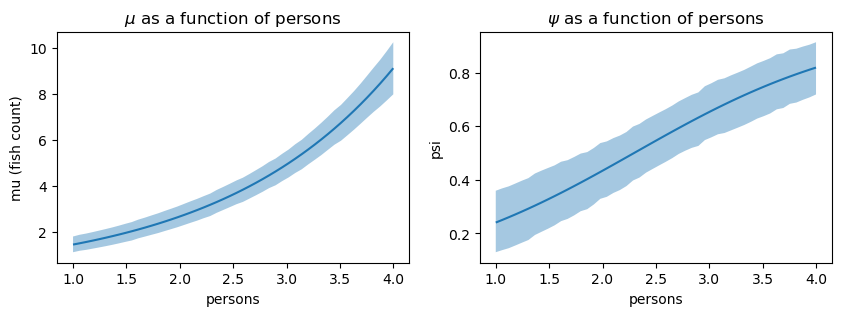

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

bmb.interpret.plot_predictions(
    zip_model,
    zip_idata,
    covariates="persons",
    ax=ax[0]
)
ax[0].set_ylabel("mu (fish count)")
ax[0].set_title("$\\mu$ as a function of persons")

bmb.interpret.plot_predictions(
    zip_model,
    zip_idata,
    covariates="persons",
    target="psi",
    ax=ax[1]
)
ax[1].set_title("$\\psi$ as a function of persons");

## Hurdle regression model

In [18]:
hurdle_formula = bmb.Formula(
                                "count ~ livebait + camper + persons + child", # parent parameter mu
                                "psi ~ livebait + camper + persons + child"    # non-parent parameter psi
)

In [19]:
hurdle_model = bmb.Model(
    hurdle_formula, 
    fish_data, 
    family='hurdle_poisson'
)

In [20]:
hurdle_idata = hurdle_model.fit(
    draws=1000, 
    target_accept=0.95, 
    random_seed=1234, 
    chains=4
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, livebait, camper, persons, child, psi_Intercept, psi_livebait, psi_camper, psi_persons, psi_child]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


In [21]:
az.summary(
    hurdle_idata,
    var_names=["Intercept", "livebait", "camper", "persons", "child"], 
    filter_vars="like"
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.615,0.363,-2.278,-0.915,0.006,0.005,3832.0,2121.0,1.0
livebait[1.0],1.661,0.329,1.031,2.273,0.005,0.004,4149.0,1871.0,1.0
camper[1.0],0.271,0.100,0.073,0.449,0.001,0.001,6843.0,2934.0,1.0
persons,0.610,0.045,0.533,0.700,0.001,0.000,4848.0,3196.0,1.0
child,-0.791,0.094,-0.970,-0.618,0.001,0.001,4371.0,3006.0,1.0
psi_Intercept,-2.780,0.583,-3.906,-1.715,0.008,0.006,4929.0,3258.0,1.0
psi_livebait[1.0],0.764,0.427,-0.067,1.557,0.006,0.005,5721.0,2779.0,1.0
psi_camper[1.0],0.849,0.298,0.283,1.378,0.004,0.003,5523.0,2855.0,1.0
psi_persons,1.040,0.183,0.719,1.396,0.003,0.002,3852.0,3007.0,1.0
psi_child,-2.003,0.282,-2.555,-1.517,0.004,0.003,4021.0,3183.0,1.0


In [26]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])

def plot_ppc_discrete(idata, bins, ax):
    
    def add_discrete_bands(x, lower, upper, ax, **kwargs):
        for i, (l, u) in enumerate(zip(lower, upper)):
            s = slice(i, i + 2)
            ax.fill_between(x[s], [l, l], [u, u], **kwargs)

    var_name = list(idata.observed_data.data_vars)[0]
    y_obs = idata.observed_data[var_name].to_numpy()
    
    counts_list = []
    for draw_values in az.extract(idata, "posterior_predictive")[var_name].to_numpy().T:
        counts, _ = np.histogram(draw_values, bins=bins)
        counts_list.append(counts)
    counts_arr = np.stack(counts_list)

    qts_90 = np.quantile(counts_arr, (0.05, 0.95), axis=0)
    qts_70 = np.quantile(counts_arr, (0.15, 0.85), axis=0)
    qts_50 = np.quantile(counts_arr, (0.25, 0.75), axis=0)
    qts_30 = np.quantile(counts_arr, (0.35, 0.65), axis=0)
    median = np.quantile(counts_arr, 0.5, axis=0)

    colors = [adjust_lightness("C0", x) for x in [1.8, 1.6, 1.4, 1.2, 0.9]]

    add_discrete_bands(bins, qts_90[0], qts_90[1], ax=ax, color=colors[0])
    add_discrete_bands(bins, qts_70[0], qts_70[1], ax=ax, color=colors[1])
    add_discrete_bands(bins, qts_50[0], qts_50[1], ax=ax, color=colors[2])
    add_discrete_bands(bins, qts_30[0], qts_30[1], ax=ax, color=colors[3])

    
    ax.step(bins[:-1], median, color=colors[4], lw=2, where="post")
    ax.hist(y_obs, bins=bins, histtype="step", lw=2, color="black", align="mid")
    handles = [
        Line2D([], [], label="Observed data", color="black", lw=2),
        Line2D([], [], label="Posterior predictive median", color=colors[4], lw=2)
    ]
    ax.legend(handles=handles)
    return ax

In [24]:
hurdle_pps = hurdle_model.predict(idata=hurdle_idata, kind="pps", inplace=False)

In [25]:
bins = np.arange(39)

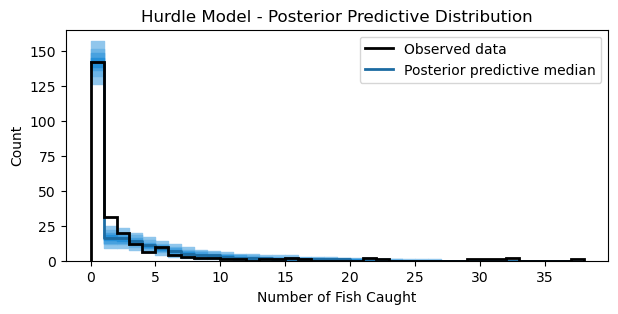

In [28]:
fig, ax = plt.subplots(figsize=(7, 3))
ax = plot_ppc_discrete(hurdle_pps, bins, ax)
ax.set_xlabel("Number of Fish Caught")
ax.set_ylabel("Count")
ax.set_title("Hurdle Model - Posterior Predictive Distribution");